In [1]:
# %% [code]
# !pip install --upgrade torch_pruning
# !pip install ipywidgets
# !pip install matplotlib
# !pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu128

import torch
import torchvision
import torch_pruning as tp
import torch.nn as nn
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

print("All libraries loaded successfully!")

# (Optional) Show the Torch-Pruning Demo banner image.
from IPython.display import Image
display(Image(url="https://github.com/VainF/Torch-Pruning/raw/master/assets/intro.png", width=400))


All libraries loaded successfully!


In [2]:
# %% [code]
# Define available models (only classification models here)
model_dict = {
    'resnet50': torchvision.models.resnet50,
    'resnet18': torchvision.models.resnet18,
    'convnext': torchvision.models.convnext_base,
    'vgg_19_bn': torchvision.models.vgg19_bn,
    'regnet_x_1_6gf': torchvision.models.regnet_x_1_6gf,
    'efficientnet_b4': torchvision.models.efficientnet_b4,
    'densenet121': torchvision.models.densenet121,
    'vit_b_32': torchvision.models.vit_b_32,
    'mobilenet_v3_large': torchvision.models.mobilenet_v3_large,
}

# Create interactive dropdown & button to choose and load a model.
model_dropdown = widgets.Dropdown(options=list(model_dict.keys()),
                                  value='convnext',
                                  description="Select Model:")

load_button = widgets.Button(description="Load Model",
                             button_style="success")

# This global variable will store the loaded model.
global_model = None

def load_model_fn(b):
    global global_model
    clear_output(wait=True)
    print("Loading model '{}' ...".format(model_dropdown.value))
    # Load with pretrained weights (this might take a minute if downloading)
    global_model = model_dict[model_dropdown.value](pretrained=True)
    print("Model loaded successfully!\n")
    # Display a truncated summary (printing the whole model can be overwhelming):
    print("Model architecture (summary):")
    print(global_model)
    # Optionally, display some quick stats:
    dummy_input = torch.randn(1, 3, 224, 224)
    base_macs, base_nparams = tp.utils.count_ops_and_params(global_model, dummy_input)
    print("\nBaseline statistics:")
    print("MACs: {:.2f} G, Params: {:.2f} M".format(base_macs/1e9, base_nparams/1e6))
    print("\nNow, scroll down to adjust pruning parameters and run pruning!")
    # Redisplay the model selection widget below for convenience.
    display(widgets.VBox([model_dropdown, load_button]))

load_button.on_click(load_model_fn)
display(widgets.VBox([model_dropdown, load_button]))


Loading model 'vit_b_32' ...


c:\Users\tahaa\Downloads\Torch Prune Testing\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tahaa\Downloads\Torch Prune Testing\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!

Model architecture (summary):
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((

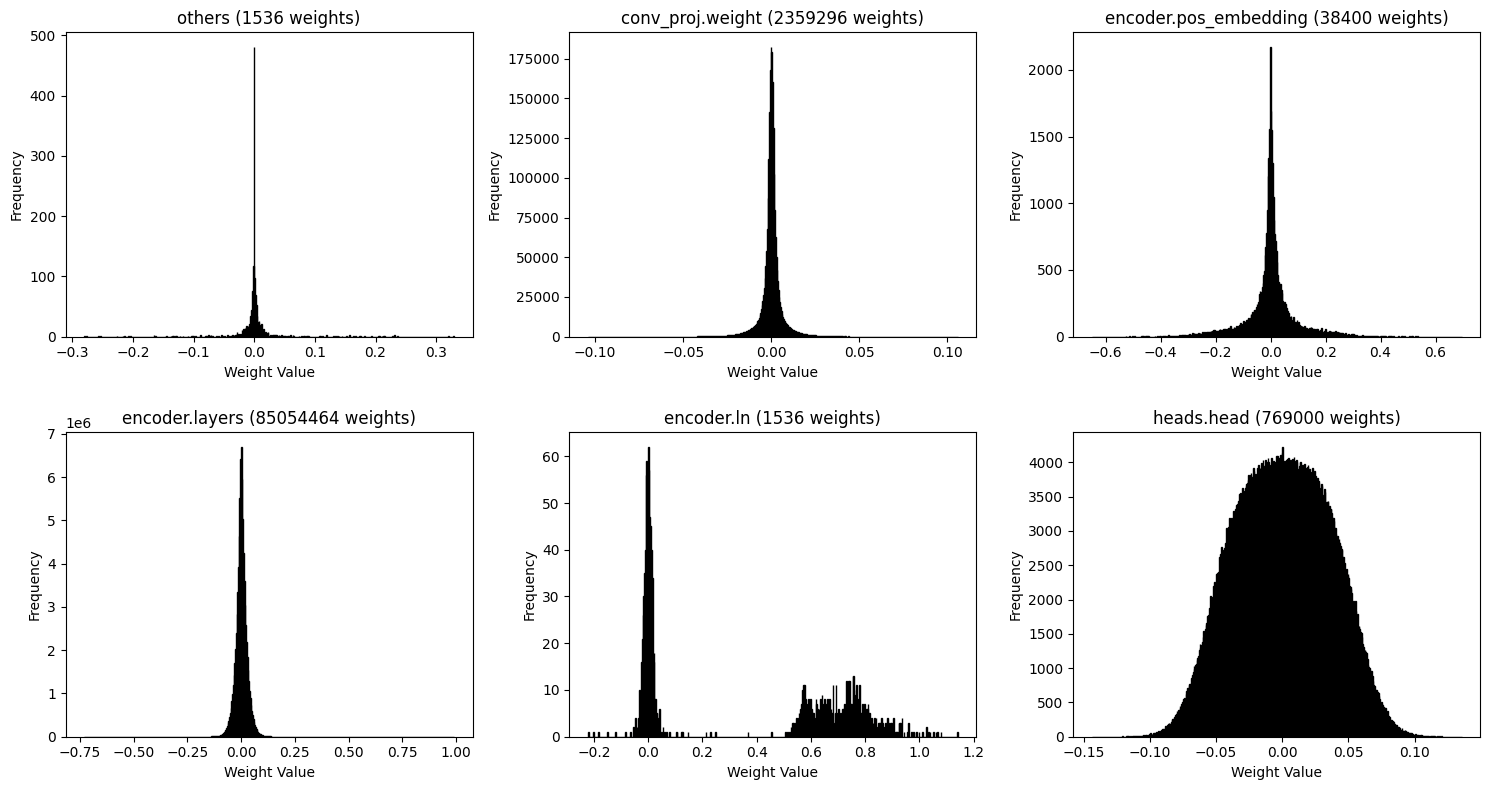

In [7]:
# ----- Weight Distribution by Layer/Group -----
import math

# Group parameters by a heuristic: use the first two tokens from the parameter name, if available.
groups = {}
for name, param in global_model.named_parameters():
    parts = name.split('.')
    group_key = ".".join(parts[:2]) if len(parts) >= 2 else parts[0]
    groups.setdefault(group_key, []).append(param.view(-1))

# Merge the tensors for each group into one
for key in groups:
    groups[key] = torch.cat(groups[key])

# For clarity, merge groups with fewer than a threshold number of parameters into a single "others" group
threshold = 1000
merged_groups = {}
for key, tensor in groups.items():
    if tensor.numel() < threshold:
        merged_groups.setdefault("others", []).append(tensor)
    else:
        merged_groups[key] = tensor

if "others" in merged_groups:
    merged_groups["others"] = torch.cat(merged_groups["others"])

# Plot a histogram for each group
num_groups = len(merged_groups)
cols = min(3, num_groups)
rows = math.ceil(num_groups / cols)
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
if num_groups == 1:
    axs = [axs]
elif rows > 1:
    axs = axs.flatten()
else:
    axs = list(axs)

for ax, (group, data) in zip(axs, merged_groups.items()):
    data_np = data.detach().numpy()
    ax.hist(data_np, bins=500, color="#1f77b4", edgecolor="black")
    ax.set_title(f"{group} ({data.numel()} weights)")
    ax.set_xlabel("Weight Value")
    ax.set_ylabel("Frequency")

# Remove extra subplots if any
for ax in axs[len(merged_groups):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [21]:
# ============================================================================
# Interactive Widgets Setup
# ============================================================================
pruning_ratio_slider = widgets.FloatSlider(
    value=0.2, 
    min=0.0, 
    max=0.9, 
    step=0.05,
    description='Pruning Ratio:',
    continuous_update=False
)

iterative_steps_slider = widgets.IntSlider(
    value=1, 
    min=1, 
    max=10, 
    step=1,
    description='Iterative Steps:',
    continuous_update=False
)

global_pruning_checkbox = widgets.Checkbox(
    value=False, 
    description='Global Pruning'
)

run_pruning_button = widgets.Button(
    description="Run Pruning", 
    button_style="warning"
)

def create_vit_dummy_input(model):
    """Create a dummy input for a Vision Transformer model that respects the expected patch dimensions."""
    # Check if the model has a patch_embed attribute with img_size
    if hasattr(model, 'patch_embed') and hasattr(model.patch_embed, 'img_size'):
        img_size = model.patch_embed.img_size
        if isinstance(img_size, (tuple, list)):
            img_size = img_size[0]  # assume square image
    else:
        # If not available, fallback to a default that leads to 7x7 patches; adjust as needed for your model
        img_size = 224  # e.g., 112 = 7*16, if patch size is 16
    return torch.randn(1, 3, img_size, img_size)


def count_parameters(model):
    """Return total and non-zero model parameters."""
    total_params = sum(p.numel() for p in model.parameters())
    nonzero_params = sum(torch.count_nonzero(p).item() for p in model.parameters())
    return total_params, nonzero_params


def run_pruning_fn(b):
    global global_model
    clear_output(wait=True)
    
    # Model validation
    if global_model is None:
        print("Please load a model first (see the model selection cell)!")
        return
    
    print(f"Preparing to prune model '{model_dropdown.value}' ...")
    dummy_input = torch.randn(1, 3, 224, 224)

    
    # ============================================================================
    # Baseline Statistics
    # ============================================================================

    # Get baseline statistics
    base_total, base_nonzero = count_parameters(global_model)
    print(f"\nTotal Summary:")
    print(f"Total parameters: {base_total:,}")
    print(f"Non-zero parameters: {base_nonzero:,}")
    print(f"Sparsity: {100 * (1 - base_nonzero/base_total):.2f}%")
    
    # ============================================================================
    # Pruning Setup
    # ============================================================================
    # 1. Importance estimator
    imp = tp.importance.GroupNormImportance(p=2)
    
    # 2. Identify layers to ignore (e.g., classifier layers)
    ignored_layers = [
        m for m in global_model.modules() 
        if isinstance(m, torch.nn.Linear) and m.out_features == 1000
    ]
    
    # 3. Set up channel groups (e.g., for MultiheadAttention)
    channel_groups = {
        m: m.num_heads for m in global_model.modules() 
        if isinstance(m, nn.MultiheadAttention)
    }
    
    # 4. Create and configure the pruner
    # pruner = tp.pruner.GroupNormPruner(
    #     model=global_model,
    #     example_inputs=dummy_input,
    #     importance=imp,
    #     global_pruning=global_pruning_checkbox.value,
    #     pruning_ratio=pruning_ratio_slider.value,
    #     iterative_steps=iterative_steps_slider.value,
    #     ignored_layers=ignored_layers,
    #     channel_groups=channel_groups,
    # )
    pruner = tp.pruner.MagnitudePruner(
    model=global_model,
    example_inputs=dummy_input,
    importance=tp.importance.MagnitudeImportance(),  # L1 norm by default
    pruning_ratio=pruning_ratio_slider.value,
    iterative_steps=iterative_steps_slider.value,
    ignored_layers=ignored_layers,
)
    
    # ============================================================================
    # Pruning Execution
    # ============================================================================
    print(">> Starting pruning ...")
    pruner.step()
    
    # Special handling for VisionTransformer models
    from torchvision.models.vision_transformer import VisionTransformer

    if isinstance(global_model, VisionTransformer):
        global_model.hidden_dim = global_model.conv_proj.out_channels
    
    # Get pruned statistics
    pruned_total, pruned_nonzero = count_parameters(global_model)
    
    # ============================================================================
    # Results Display
    # ============================================================================
    print("\nPruned model:")
    print(global_model)
    
    print("\nSummary:")
    print(f"Params: {base_nparams/1e6:.2f} M  ==> {pruned_nparams/1e6:.2f} M")
    print(f"MACs: {base_macs/1e9:.2f} G  ==> {pruned_macs/1e9:.2f} G")
    
    # ============================================================================
    # Visualization
    # ============================================================================
    # 1. Bar Chart: Model Complexity Comparison
    labels = ['Params (M)', 'MACs (G)']
    before = [base_nparams/1e6, base_macs/1e9]
    after = [pruned_nparams/1e6, pruned_macs/1e9]
    
    x = range(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar([p - width/2 for p in x], before, width, label="Before", color="#1f77b4")
    ax.bar([p + width/2 for p in x], after, width, label="After", color="#ff7f0e")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Count")
    ax.set_title("Model Complexity Before & After Pruning")
    ax.legend()
    plt.show()
    
    # 2. Pie Charts: Pruned vs Remaining Distribution
    labels_pie = ["Pruned", "Remaining"]
    sizes_params = [base_nparams - pruned_nparams, pruned_nparams]
    sizes_macs = [base_macs - pruned_macs, pruned_macs]
    
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.pie(sizes_params, labels=labels_pie, autopct='%1.1f%%', colors=["#ff7f0e", "#1f77b4"])
    ax1.set_title("Parameter Distribution")
    ax2.pie(sizes_macs, labels=labels_pie, autopct='%1.1f%%', colors=["#ff7f0e", "#1f77b4"])
    ax2.set_title("MACs Distribution")
    plt.show()
    
    # 3. Histogram: Weight Distribution
    all_weights = []
    for name, param in global_model.named_parameters():
        all_weights.extend(param.data.cpu().numpy().flatten())
    
    plt.figure(figsize=(8, 5))
    plt.hist(all_weights, bins=50, color="#1f77b4", edgecolor="black")
    plt.title("Weight Distribution of Pruned Model")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()
    
    # ============================================================================
    # Model Validation
    # ============================================================================
    print("\nPerforming a quick forward and backward test...")
    output = global_model(dummy_input)
    print("Output shape:", output.shape)
    loss = torch.nn.functional.cross_entropy(output, torch.randint(0, 1000, (1,)))
    loss.backward()
    print("Forward & backward test passed!")
    
    # Re-display widgets
    display(widgets.VBox([
        pruning_ratio_slider,
        iterative_steps_slider,
        global_pruning_checkbox,
        run_pruning_button,
    ]))

# ============================================================================
# Widget Display Setup
# ============================================================================
run_pruning_button.on_click(run_pruning_fn)
display(widgets.VBox([
    pruning_ratio_slider,
    iterative_steps_slider,
    global_pruning_checkbox,
    run_pruning_button,
]))

Preparing to prune model 'vit_b_32' ...

Total Summary:
Total parameters: 62,670,490
Non-zero parameters: 62,670,490
Sparsity: 0.00%


RuntimeError: shape '[1, 768, 49]' is invalid for input of size 31605

In [11]:
type(global_model)

torchvision.models.vision_transformer.VisionTransformer

In [ ]:
# ----- Dense Model Weight Distribution (Before Pruning) -----
all_weights_dense = []
for name, param in global_model.named_parameters():
    all_weights_dense.extend(param.data.cpu().numpy().flatten())

plt.figure(figsize=(8, 5))
plt.hist(all_weights_dense, bins=50, color="#2ca02c", edgecolor="black")
plt.title("Weight Distribution of Dense (Original) Model")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()